# Sparse direct solvers

This notebook illustrate the sparse Cholesky factorization, using the example of the matrix obtained from a finite difference discretization of 2D Laplacian matrix with Dirichlet boundary condition.

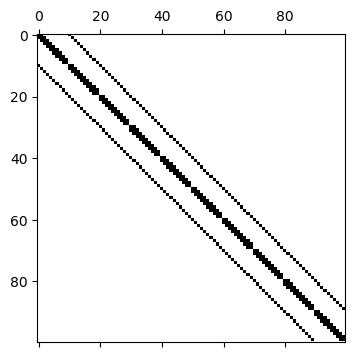

PyObject <matplotlib.image.AxesImage object at 0x000000002F37BC50>

In [1]:
using SparseArrays
using LinearAlgebra
function Lap2D(N)
    # N: number of grid per dimension
    I_N = sparse(1.0I, N, N)
    L1D = spdiagm(-1=>-ones(N-1), 0=>2.0*ones(N), 1=>-ones(N-1))
    A = kron(L1D,I_N)+kron(I_N,L1D)
    return A
end
    
N = 10 # number of grid per dimension
A = Lap2D(N)

using PyPlot
figure(figsize=(4,4))
spy(A)

In [2]:
N=60
A=Lap2D(N)

b=randn(N*N)

println("Use dense solver")
@time Matrix(A)\b;
println("Use sparse solver")
@time cholesky(A) \ b;

Use dense solver
  2.585736 seconds (4.48 M allocations: 415.751 MiB, 10.87% gc time)
Use sparse solver
  0.257363 seconds (590.94 k allocations: 33.149 MiB, 3.95% gc time)


### Our own implementation of Cholesky factorization



In [3]:
function mychol(A0)
    # Assume A0 is a symmetric positive definite matrix.
    # This code is not an efficient implementation
    A = copy(A0)
    M = size(A,1)
    L = spzeros(M,M)
    for k = 1 : M
        L[k,k] = sqrt(A[k,k])
        # Find the nonzero indices
        # This line is conceptually correct but very cache unfriendly
        ind = k .+ findall(x->x!=0,A[k+1:end,k])
        if(~isempty(ind)) 
            L[ind,k] = A[ind,k] / L[k,k]
            # right-looking version of update
            A[ind,ind] -= L[ind,k]*L[ind,k]'
        end
    end
    return L
end

function mycholsolve(L,b)
    # Assume L is obtained from mychol, and b is a vector
    # This is not an efficient implementation
    M = size(L,1)
    x = zeros(M)
    y = zeros(M)
    # Forward substitution
    for k = 1 : M
        # Pay attention to the sparsity pattern
        ind = findall(x->x!=0,L[k,1:k-1])
        y[k] = b[k]
        if(~isempty(ind))
            y[k] -= sum(vec(L[k,ind]).*y[ind])
        end
        y[k] /= L[k,k]
    end
    # Backward substitution
    for k = M : -1 : 1
        ind = k .+ findall(x->x!=0,L[k+1:end,k])
        x[k] = y[k]
        if(~isempty(ind))
            x[k] -= sum(vec(L[ind,k]).*x[ind])
        end
        x[k] /= L[k,k]
    end
    return x
end

mycholsolve (generic function with 1 method)

Our solver is accurate.

In [4]:
N=10
b=randn(N*N)
A=Lap2D(N)
L=mychol(A)
myx=mycholsolve(L,b)
xexact = cholesky(A)\b
println("||x-xexact||_2=",norm(myx-xexact))


||x-xexact||_2=4.9550237625725755e-15


However, it seems to be **a lot** slower.

In [5]:
N=40
A=Lap2D(N)
b=randn(N*N)

println("Use sparse solver cholfact")
@time cholesky(A) \ b;
println("Use my sparse solver")
@time L=mychol(A);mycholsolve(L,b);

Use sparse solver cholfact
  0.002806 seconds (44 allocations: 1017.563 KiB)
Use my sparse solver
  2.330951 seconds (127.50 k allocations: 2.640 GiB, 14.54% gc time)


The Cholesky factor is still sparse but denser than the original matrix.

Block tridiagonal structure of the Cholesky factor (under the natural ordering).

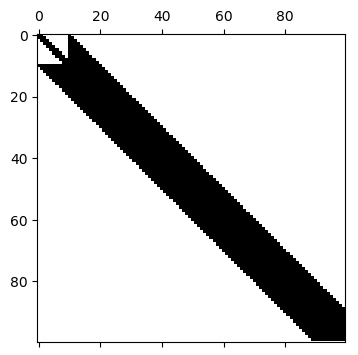

nnz(A)=460
nnz(L+L')=1918


In [6]:
N=10
b=randn(N*N)
A=Lap2D(N)
L=mychol(A)

figure(figsize=(4,4))
spy(L+L')
println("nnz(A)=",nnz(A))
println("nnz(L+L')=",nnz(L+L'))


Compare to triangular matrix

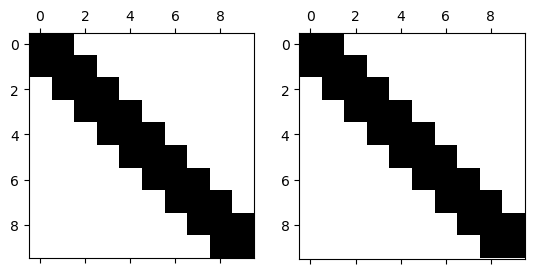

PyObject <matplotlib.image.AxesImage object at 0x000000002F3D2588>

In [7]:
N=10
L1D = spdiagm(-1=>-ones(N-1), 0=>2.0*ones(N), 1=>-ones(N-1))
L=mychol(L1D)

figure(1)
subplot(1,2,1)
spy(L1D)

subplot(1,2,2)
spy(L+L')


### Matrix ordering is the key

In [8]:
## Implementing the nested disection ordering for 2D Laplacian on a m*n grid

function nestdisect(m,n, nlevel=10, lda=m)
    if nlevel <= 0 || m*n < 10 
        return reshape([i + (j-1)*lda for i=1:m, j=1:n], m*n)
    elseif m >= n
        msep = div(m,2)
        n1 = nestdisect(msep-1,n, nlevel-1, lda)
        n2 = nestdisect(m-msep,n, nlevel-1, lda) .+ msep
        ns = msep .+ (0:n-1)*lda
        return [n1; n2; ns]
    else
        nsep = div(n,2)
        n1 = nestdisect(m,nsep-1, nlevel-1, lda)
        n2 = nestdisect(m,n-nsep, nlevel-1, lda) .+ nsep*lda
        ns = (1:m) .+ (nsep-1)*lda
        return [n1; n2; ns]
    end
end

nestdisect (generic function with 3 methods)

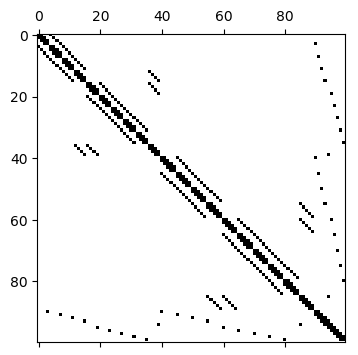

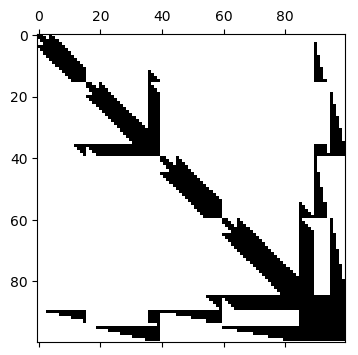

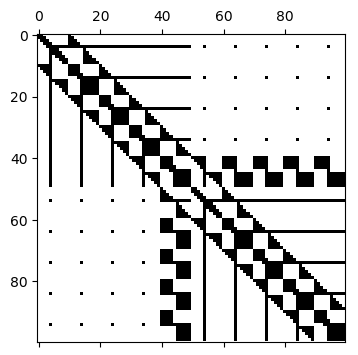

nnz(L+L')=1822


PyObject <matplotlib.image.AxesImage object at 0x000000003DF25080>

In [9]:
N=10
b=randn(N*N)
A=Lap2D(N)
perm=nestdisect(N,N,2)
# Key: permute the matrix
B=A[perm,perm]
L=mychol(B)

figure(1,figsize=(4,4))
spy(B)

figure(2,figsize=(4,4))
C = L+L'
spy(C)
println("nnz(L+L')=",nnz(L+L'))

# Back to original ordering
figure(3,figsize=(4,4))
D = spzeros(N*N,N*N)
D[perm,perm] = C
spy(D)


 33.795260 seconds (459.03 k allocations: 40.804 GiB, 13.61% gc time)
  0.260508 seconds (394.43 k allocations: 309.217 MiB, 8.71% gc time)
nnz(L+L')=681238
  8.599821 seconds (406.88 k allocations: 14.279 GiB, 13.73% gc time)
  0.189687 seconds (264.48 k allocations: 225.656 MiB, 11.84% gc time)


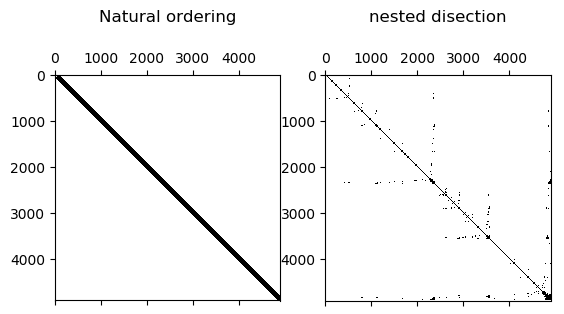

nnz(L+L')=220330


In [10]:
# Matrix of larger sizes

N=70
b=randn(N*N)
A=Lap2D(N)

@time L=mychol(A)
@time mycholsolve(L,b);
figure(1)
subplot(1,2,1)
spy(L+L')
title("Natural ordering",y=1.2)
println("nnz(L+L')=",nnz(L+L'))

perm=nestdisect(N,N,10)
B=A[perm,perm]

@time L=mychol(B)
@time mycholsolve(L,b);

subplot(1,2,2)

spy(L+L')
title("nested disection",y=1.2)
println("nnz(L+L')=",nnz(L+L'))


Still not as fast. This is because this is really a naive implementation. Modern sparse Cholesky/LU factorization improves this algorithm from various aspects: blocking (for taking advantage of BLAS3, i.e. matrix-matrix operations instead of matrix-vector or vector-vector operations), symbolic factorization (pre-allocation of storage space for nonzero elements of L) etc.


### Verify the scaling

In [ ]:
NList = 10:10:100
MList = NList.^2
nnzLNatural = zeros(size(NList))
nnzLND = zeros(size(NList))
for l = 1 : length(NList)
    N = NList[l]
    println("N=",N)
    A = Lap2D(N)
    perm = nestdisect(N,N,30)
    B = A[perm,perm]
    nnzLNatural[l] = nnz(mychol(A))
    nnzLND[l] = nnz(mychol(B))
end


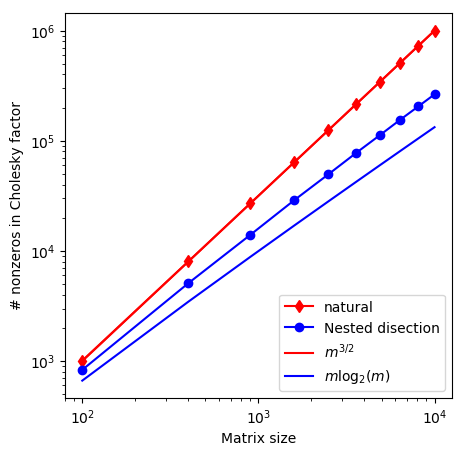

PyObject <matplotlib.legend.Legend object at 0x000000002B5AC278>

In [13]:

figure(figsize=(5,5))

loglog(MList, nnzLNatural, "r-d")
loglog(MList, nnzLND, "b-o")
loglog(MList, MList.^(3/2), "r-")
loglog(MList, MList .* log2.(MList), "b-")

xlabel("Matrix size")
ylabel("# nonzeros in Cholesky factor")
legend(["natural", "Nested disection", L"m^{3/2}", L"m \log_2(m)"], loc="lower right")